In [47]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster, sklearn.preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [24]:
input_file = 'kakao_review_result.csv'
df_kakao = pd.read_csv(input_file)
df_kakao

,ID,WRITER,CONTENT,TYPE,SCORE,CREATED_AT,RENTAL_CAR_ID
0,0,미식가고양이,거짓후기인가... 직원분들 모두 친절하고 셔틀도 바로 오시던데 신차급차량과 렌트비도...,카카오맵,5,22.11.20.,2
1,1,♤♡♤,별도 아깝네요. 그래도 다른 여직원분은 설명도 잘해주시고 친절했는데 반납할때 다른 ...,카카오맵,1,22.11.05.,2
2,2,ㅇㅇ,별하나도 아깝네요 불친절에 바가지 지대로고요 다시는 안갈듯. 기분좋게 여행하려 수...,카카오맵,1,22.08.24.,2
3,3,클리너,"원래 이런거 귀찮아서 안올리는데, 혹시 저와 같은 피해자가 또 생길까 봐서 참고하...",카카오맵,1,22.07.19.,2
4,4,도라이몽,카운터에 있는 여자남자 둘다 진짜 심각함. 제주도 촌이라서 아무나 쓰는 건지.. 사...,카카오맵,1,22.03.08.,2
...,...,...,...,...,...,...,...
2694,2694,거긴어디,다신 안감,카카오맵,1,19.06.26.,113
2695,2695,Leeyongsook,별 하나도 아까운 곳~서비스 개엉망에 졸싸가지없는여직원렌트카하나때문에 기분 바가지로...,카카오맵,1,19.06.15.,113
2696,2696,♡행복한사람♡,퍼시픽렌트카에서 K7 빌려서 여행 3일째 저녁에 공기압 떴어요.저흰 완전자차만했는데...,카카오맵,1,19.06.10.,113
2697,2697,정재용,계약서에 기입한 기름 퍼센티지 정확히 확인바람.출발전 찍은 기름양만큼 넣지만 기름양...,카카오맵,1,19.06.01.,113


In [25]:
df_kakao_temp = pd.concat([df_kakao['CONTENT'],df_kakao['SCORE'],df_kakao['RENTAL_CAR_ID']], axis = 1)

In [26]:
df_kakao_temp

,CONTENT,SCORE,RENTAL_CAR_ID
0,거짓후기인가... 직원분들 모두 친절하고 셔틀도 바로 오시던데 신차급차량과 렌트비도...,5,2
1,별도 아깝네요. 그래도 다른 여직원분은 설명도 잘해주시고 친절했는데 반납할때 다른 ...,1,2
2,별하나도 아깝네요 불친절에 바가지 지대로고요 다시는 안갈듯. 기분좋게 여행하려 수...,1,2
3,"원래 이런거 귀찮아서 안올리는데, 혹시 저와 같은 피해자가 또 생길까 봐서 참고하...",1,2
4,카운터에 있는 여자남자 둘다 진짜 심각함. 제주도 촌이라서 아무나 쓰는 건지.. 사...,1,2
...,...,...,...
2694,다신 안감,1,113
2695,별 하나도 아까운 곳~서비스 개엉망에 졸싸가지없는여직원렌트카하나때문에 기분 바가지로...,1,113
2696,퍼시픽렌트카에서 K7 빌려서 여행 3일째 저녁에 공기압 떴어요.저흰 완전자차만했는데...,1,113
2697,계약서에 기입한 기름 퍼센티지 정확히 확인바람.출발전 찍은 기름양만큼 넣지만 기름양...,1,113


In [27]:
train_data = df_kakao_temp
train_data['CONTENT'].nunique(), train_data['SCORE'].nunique()

(2575, 5)

In [28]:
train_data.drop_duplicates(subset = ['CONTENT'], inplace = True)
print(f'총 샘플의 수 : {len(train_data)}')

총 샘플의 수 : 2575


In [29]:
print(train_data.isnull().sum())

CONTENT          0
SCORE            0
RENTAL_CAR_ID    0
dtype: int64


In [39]:
train_data['CONTENT'] = train_data['CONTENT'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')
train_data[:5]

C:\Users\tj\AppData\Local\Temp\ipykernel_12224\1586705489.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['CONTENT'] = train_data['CONTENT'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')


,CONTENT,SCORE,RENTAL_CAR_ID
0,거짓후기인가 직원분들 모두 친절하고 셔틀도 바로 오시던데 신차급차량과 렌트비도 모두...,5,2
1,별도 아깝네요 그래도 다른 여직원분은 설명도 잘해주시고 친절했는데 반납할때 다른 여...,1,2
2,별하나도 아깝네요 불친절에 바가지 지대로고요 다시는 안갈듯 기분좋게 여행하려 수많...,1,2
3,원래 이런거 귀찮아서 안올리는데 혹시 저와 같은 피해자가 또 생길까 봐서 참고하시...,1,2
4,카운터에 있는 여자남자 둘다 진짜 심각함 제주도 촌이라서 아무나 쓰는 건지 사람 좀...,1,2


In [41]:
train_data['CONTENT'] = train_data['CONTENT'].str.replace('^ +','') # 공백문자를 지우기
train_data['CONTENT'].replace('', np.nan, inplace = True)
print(train_data.isnull().sum()) # nan값 세기

CONTENT          17
SCORE             0
RENTAL_CAR_ID     0
dtype: int64


C:\Users\tj\AppData\Local\Temp\ipykernel_12224\1025747114.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['CONTENT'] = train_data['CONTENT'].str.replace('^ +','') # 공백문자를 지우기


In [42]:
train_data.loc[train_data.CONTENT.isnull()][:5]

,CONTENT,SCORE,RENTAL_CAR_ID
21,NaN,1,3
265,NaN,5,6
342,NaN,5,12
426,NaN,5,15
862,NaN,5,38


In [43]:
train_data = train_data.dropna(how = 'any') # nan값 버리기
print(len(train_data)) # nan값 버린후 데이터 수 세기

2558


In [50]:
okt = Okt()
X_train = []
for sentence in tqdm(train_data['CONTENT']):
    tokenized_sentence = okt.morphs(sentence, stem = True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 2558/2558 [00:27<00:00, 92.47it/s]


In [51]:
print(X_train[:3])

[['거짓', '후기', '인가', '직원', '분들', '모두', '친절하다', '셔틀', '바로', '오다', '신차', '급', '차량', '렌트', '비도', '모두', '만족', '오버', '되다', '연료', '합리', '적', '환불', '해주다', '심다', '제', '주', '여행', '때', '이용', '계획', '이다'], ['별도', '아깝다', '그래도', '다른', '여직원', '분', '설명', '해주다', '친절하다', '반납', '때', '다른', '여', '직원', '분', '완전', '싸다', '없다', '얘기', '떽떽', '거려', '서', '즐겁다', '제주', '여행', '마무리', '집', '오다', '그', '지', '같다', 'ㅡㅡ'], ['별하나', '아깝다', '불친절', '바가지', '지', '대', '로고', '요', '다시다', '안', '갈다', '기분', '좋다', '여행', '수많다', '계획', '을', '짜다', '오다', '렌트카', '완전', '재우', '탱', '이쁘다', '대다', '쓰다']]


In [89]:
# 단어 리스트로 변환
def flatten(l):
    flatList = []
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList

word_list=flatten(X_train)
word_list[:1]

['거짓']

In [90]:
# 두글자 이상인 단어만 추출
word_list=pd.Series([x for x in word_list if len(x)>1])
word_list.value_counts().head(10)

없다     1045
차량      983
있다      981
이용      935
반납      928
좋다      913
직원      869
렌트카     721
에서      634
보다      604
dtype: int64

In [91]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [92]:
add_s = "때 분 곳 여기 것 말 안 그냥 더 함 정도 진짜 다른"
add_s = add_s.split()
stopwords = stopwords + add_s
len(stopwords)

31

In [93]:
def __array__(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()

def to_array(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return np.array(self.to_image())
array = wordcloud.to_array()
array.shape

(800, 800, 3)

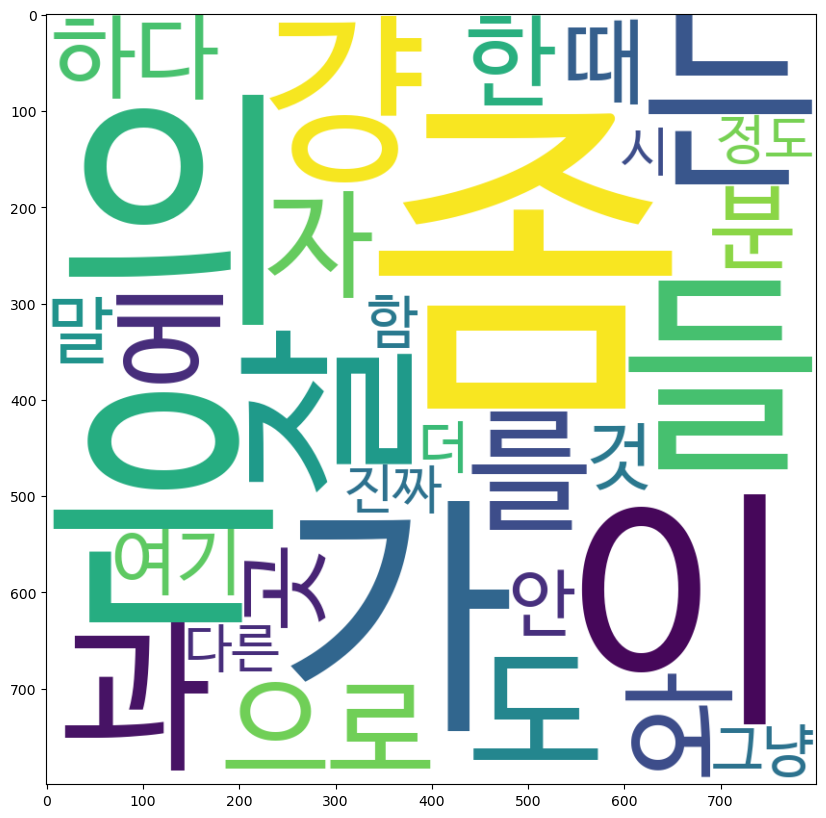

In [94]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(array, interpolation="bilinear")
plt.show()

In [7]:
input_file = 'naver_re.csv'
df_naver = pd.read_csv(input_file)
df_naver

,ID,WRITER,CONTENT,TYPE,SCORE,CREATED_AT,RENTAL_CAR_ID,image
0,0,다그런것,친절해요,네이버,NaN,22.12.30.금,1,[]
1,1,2rm****,굿,네이버,NaN,21.10.26.화,1,[]
2,2,양많은여성,"돌하루팡에서 연결시켜준 곳. 무상으로 업그레이드도 해주고, 엄청 친절은 아니지만 차...",네이버,4.16,1.9.월,2,[]
3,3,깨비9372,굿,네이버,4.16,1.4.수,2,[]
4,4,연두47,첫 이용인데 생각보다 괜찮고 가격도 좋았어요(20 15),네이버,4.16,1.3.화,2,[]
...,...,...,...,...,...,...,...,...
12284,12284,순수6283,SM6,네이버,3.54,19.12.22.일,113,[]
12285,12285,grooooo,1점도 아깝. 최악의 업체였음. 물기도 안닦은 차를 내어주질않나 그래놓고 내부 유리...,네이버,3.54,19.11.11.월,113,[]
12286,12286,h2o****,"여행책자 받았는데 할인쿠폰 같은게 도움이 됨,",네이버,3.54,19.9.7.토,113,[]
12287,12287,soh****,좋아요,네이버,3.54,19.3.20.수,113,[]


In [52]:
test_data = pd.concat([df_naver['CONTENT'],df_naver['RENTAL_CAR_ID']], axis = 1)

In [53]:
test_data['SCORE'] = ''

In [54]:
test_data

,CONTENT,RENTAL_CAR_ID,SCORE
0,친절해요,1,
1,굿,1,
2,"돌하루팡에서 연결시켜준 곳. 무상으로 업그레이드도 해주고, 엄청 친절은 아니지만 차...",2,
3,굿,2,
4,첫 이용인데 생각보다 괜찮고 가격도 좋았어요(20 15),2,
...,...,...,...
12284,SM6,113,
12285,1점도 아깝. 최악의 업체였음. 물기도 안닦은 차를 내어주질않나 그래놓고 내부 유리...,113,
12286,"여행책자 받았는데 할인쿠폰 같은게 도움이 됨,",113,
12287,좋아요,113,


In [55]:
test_data.drop_duplicates(subset = ['CONTENT'], inplace = True) # document 열에서 중복데이터 삭제
test_data['CONTENT'] = test_data['CONTENT'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','') # 정규 표현식으로 문자외 데이터 empty값으로
test_data['CONTENT'] = test_data['CONTENT'].str.replace('^ +','') # 공백을 empty값으로 변경
test_data['CONTENT'].replace('', np.nan, inplace = True)  # empty 값을 nan값으로 변경
test_data = test_data.dropna(how = 'any') # nan값 제거
print(f'전처리 후 테스트용 샘플의 개수 : {len(test_data)}')

전처리 후 테스트용 샘플의 개수 : 6660


C:\Users\tj\AppData\Local\Temp\ipykernel_12224\1284933107.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['CONTENT'] = test_data['CONTENT'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','') # 정규 표현식으로 문자외 데이터 empty값으로
C:\Users\tj\AppData\Local\Temp\ipykernel_12224\1284933107.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['CONTENT'] = test_data['CONTENT'].str.replace('^ +','') # 공백을 empty값으로 변경


In [57]:
X_test = []
for sentence in tqdm(test_data['CONTENT']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 6660/6660 [00:30<00:00, 220.81it/s]


In [58]:
print(X_test[:3])

[['친절하다'], ['굿'], ['돌다', '루팡', '에서', '연결', '시키다', '준', '곳', '무상', '업그레이드', '해주다', '엄청', '친절', '아니다', '차', '상태', '새', '차', '처럼', '깨끗하다', '만족스럽다', '연료', '충전', '않다']]
